# Business Problem
### Problem Context
Patients with Liver disease have been continuously increasing because of excessive consumption of alcohol, inhale of harmful gases, intake of contaminated food, pickles and drugs. This dataset was used to evaluate prediction algorithms in an effort to reduce burden on doctors.

### Content
This data set contains 416 liver patient records and 167 non liver patient records collected from North East of Andhra Pradesh, India. The "Dataset" column is a class label used to divide groups into liver patient (liver disease) or not (no disease). This data set contains 441 male patient records and 142 female patient records.

Any patient whose age exceeded 89 is listed as being of age "90".

### Features:

* Age of the patient
* Gender of the patient
* Total Bilirubin
* Direct Bilirubin
* Alkaline Phosphotase
* Alamine Aminotransferase
* Aspartate Aminotransferase
* Total Protiens
* Albumin
* Albumin and Globulin Ratio
* Dataset: field used to split the data into two sets (patient with liver disease, or no disease)

##  Mapping business problem to ML problem

###  Type of Machine Learning Problem

It is a binary classification problem, where given the above set of features, we need to predict if a given patient has liver disease or not

###  Evaluation Metric (KPI)

Since this is binary classification problem, we use the following metrics:
* **Confusion matrix** - For getting a better clarity of the no of correct/incorrect predictions by the model
* **ROC-AUC** - It considers the rank of the output probabilities and intuitively measures the likelihood that model can distinguish between a positive point and a negative point. (**Note:** ROC-AUC is typically used for binary classification only). We will use AUC to select the best model.

In [581]:
# numerical computing
import numpy as np

# dataframes
import pandas as pd

# visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

from math import sqrt

# train/test split + model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc, confusion_matrix, accuracy_score

# XGBoost (works natively in Colab)
from xgboost import XGBClassifier, plot_importance

# joblib to save model
import joblib


In [582]:
df=pd.read_csv('indian_liver_patient.csv')

In [583]:
df.shape

(583, 11)

In [584]:
df.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [585]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


## Exploratory Data Analysis

Filtering categorical data

In [586]:
df.dtypes[df.dtypes=='object']

,0
Gender,object


## Distribution of Numerical Features

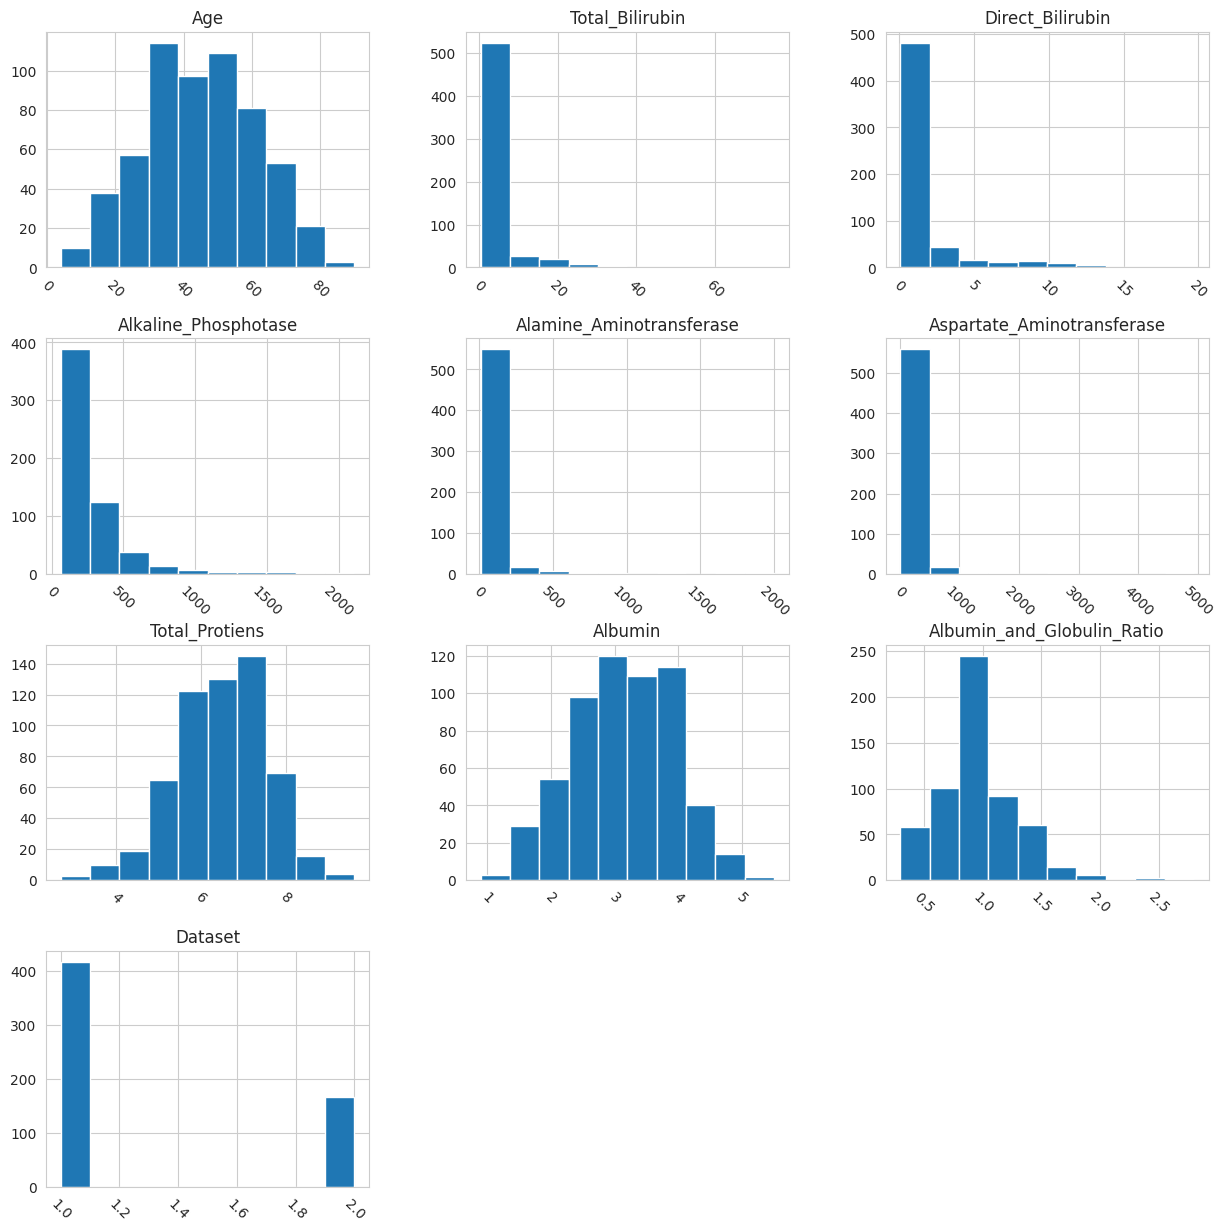

In [587]:
# Plot histogram grid
df.hist(figsize=(15,15), xrot=-45, bins=10) ## Display the labels rotated by 45 degress

# Clear the text "residue"
plt.show()

In [588]:
df.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


It seems there is outlier in Aspartate_Aminotransferase as the max value is very high than mean value

Dataset i.e output value has '1' for liver disease and '2' for no liver disease so let's make it 0 for no disease to make it convinient

In [589]:
## if score==negative, mark 0 ;else 1
def partition(x):
    if x == 2:
        return 0
    return 1

df['Dataset'] = df['Dataset'].map(partition)

## Distribution of categorical data

In [590]:
df.describe(include=['object'])

,Gender
count,583
unique,2
top,Male
freq,441


## Bar plots for categorical Features

<Axes: xlabel='count', ylabel='Gender'>

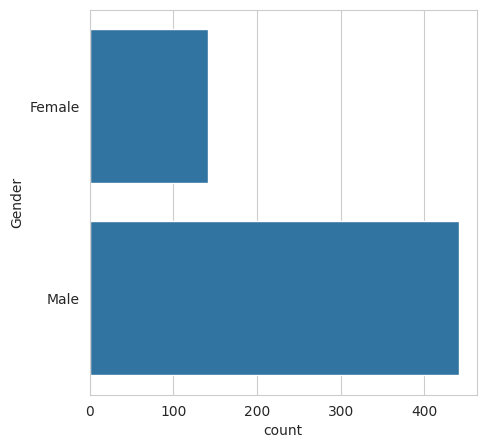

In [591]:
plt.figure(figsize=(5,5))
sns.countplot(y='Gender', data=df)

In [592]:
df[df['Gender'] == 'Male'][['Dataset', 'Gender']].head()

,Dataset,Gender
1,1,Male
2,1,Male
3,1,Male
4,1,Male
5,1,Male


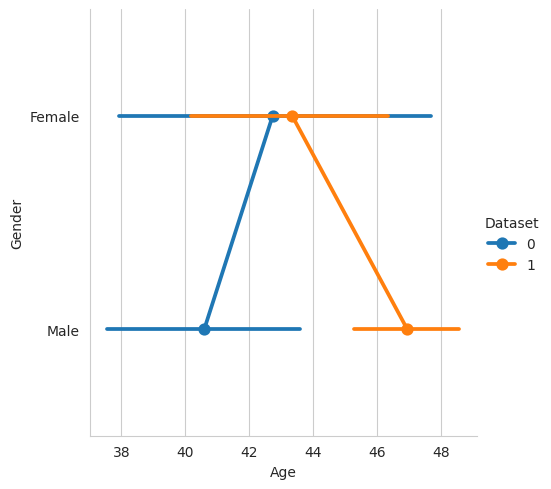

In [593]:
sns.catplot(
    x="Age",
    y="Gender",
    hue="Dataset",
    data=df,
    kind="point"     # or "bar", "box", "strip", "swarm"
)


Age seems to be a factor for liver disease for both male and female genders

Number of patients that are male:  441
Number of patients that are female:  142


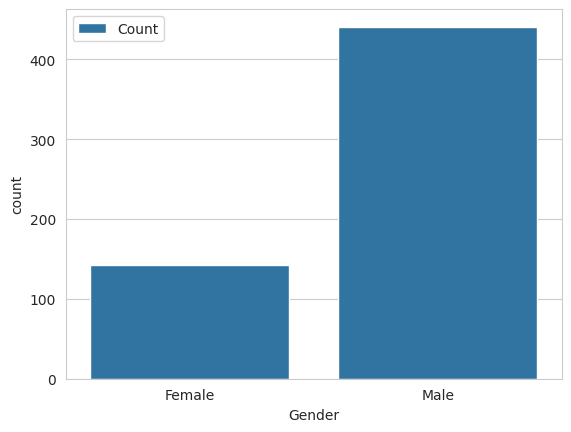

In [594]:
sns.countplot(data=df, x = 'Gender', label='Count')

M, F = df['Gender'].value_counts()
print('Number of patients that are male: ',M)
print('Number of patients that are female: ',F)

There are more male patients than female patients

Label Male as 0 and Female as 1

In [595]:
## if score==negative, mark 0 ;else 1
def partition(x):
    if x =='Male':
        return 0
    return 1

df['Gender'] = df['Gender'].map(partition)

#### 2-D Scatter Plot

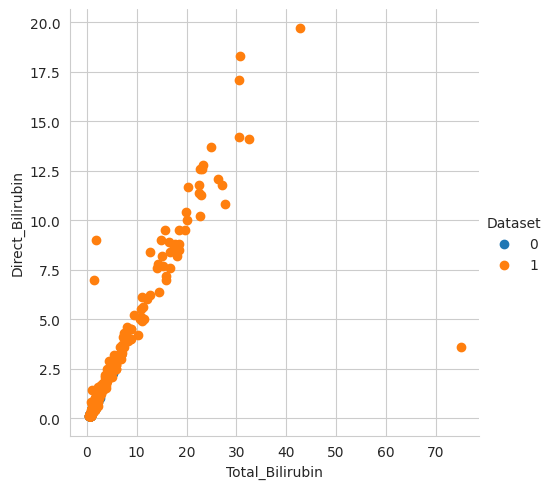

In [596]:
sns.set_style('whitegrid')   # Background Grid

g = sns.FacetGrid(df, hue='Dataset', height=5)
g.map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend()


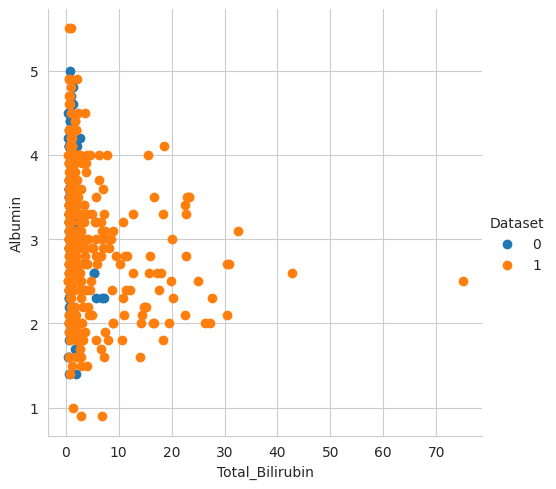

In [597]:
sns.set_style('whitegrid')   # Background Grid

g = sns.FacetGrid(df, hue='Dataset', height=5)
g.map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend()


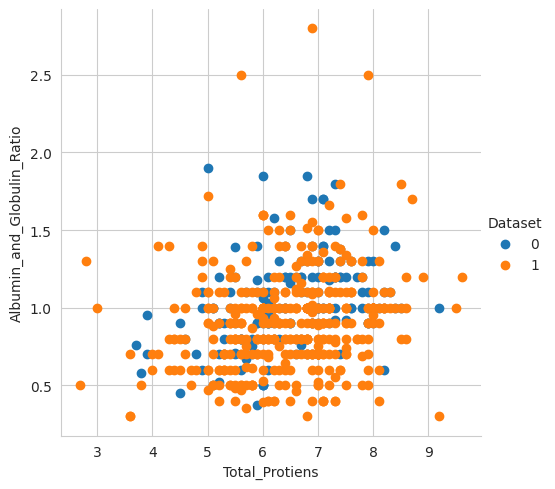

In [598]:
sns.set_style('whitegrid')   # Background Grid

g = sns.FacetGrid(df, hue='Dataset', height=5)
g.map(plt.scatter, 'Total_Protiens', 'Albumin_and_Globulin_Ratio').add_legend()


## Correlations
* Finally, let's take a look at the relationships between numeric features and other numeric features.
* ***Correlation*** is a value between -1 and 1 that represents how closely values for two separate features move in unison.
* Positive correlation means that as one feature increases, the other increases; eg. a child's age and her height.
* Negative correlation means that as one feature increases, the other decreases; eg. hours spent studying and number of parties attended.
* Correlations near -1 or 1 indicate a strong relationship.
* Those closer to 0 indicate a weak relationship.
* 0 indicates no relationship.

In [599]:
df.corr()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
Age,1.000000,-0.056560,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216408,0.137351
Gender,-0.056560,1.000000,-0.089291,-0.100436,0.027496,-0.082332,-0.080336,0.089121,0.093799,0.003424,-0.082416
Total_Bilirubin,0.011763,-0.089291,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206267,0.220208
Direct_Bilirubin,0.007529,-0.100436,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200125,0.246046
Alkaline_Phosphotase,0.080425,0.027496,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.234166,0.184866
Alamine_Aminotransferase,-0.086883,-0.082332,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002375,0.163416
Aspartate_Aminotransferase,-0.019910,-0.080336,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070040,0.151934
Total_Protiens,-0.187461,0.089121,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.234887,-0.035008
Albumin,-0.265924,0.093799,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.689632,-0.161388
Albumin_and_Globulin_Ratio,-0.216408,0.003424,-0.206267,-0.200125,-0.234166,-0.002375,-0.070040,0.234887,0.689632,1.000000,-0.163131


<Axes: >

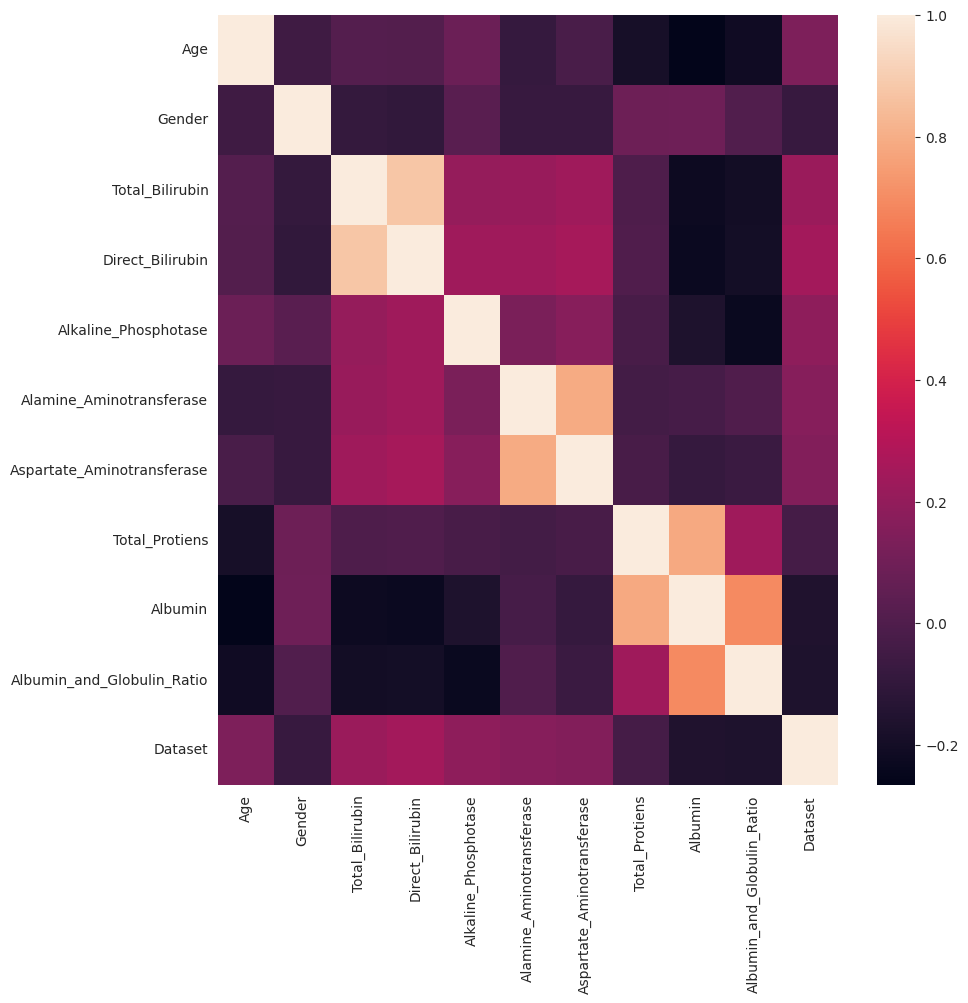

In [600]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

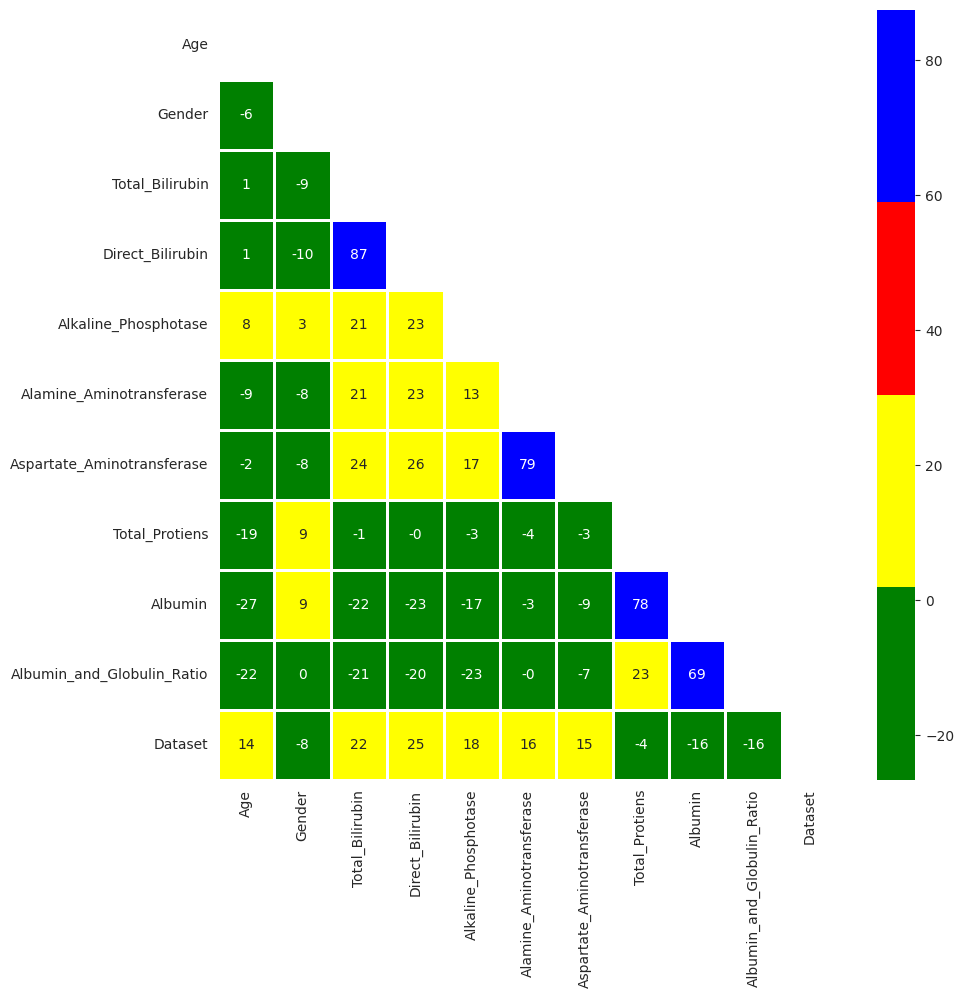

In [601]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['green', 'yellow', 'red','blue']))

## Data Cleaning

In [602]:
df = df.drop_duplicates()
print( df.shape )

(570, 11)


There were 13 duplicates

## Removing Outliers

<Axes: ylabel='Aspartate_Aminotransferase'>

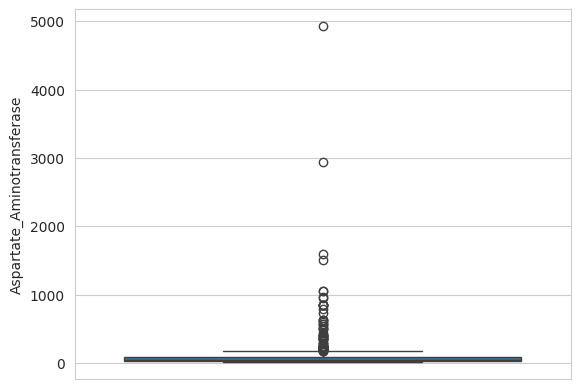

In [603]:
sns.boxplot(df.Aspartate_Aminotransferase)

In [604]:
df.Aspartate_Aminotransferase.sort_values(ascending=False).head()

,Aspartate_Aminotransferase
135,4929
117,2946
118,1600
207,1500
199,1050


In [605]:
df = df[df.Aspartate_Aminotransferase <=3000 ]
df.shape

(569, 11)

<Axes: ylabel='Aspartate_Aminotransferase'>

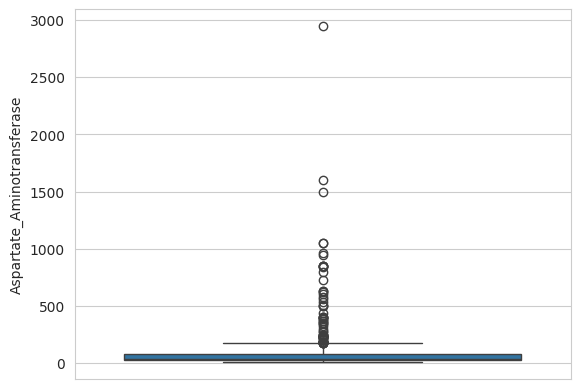

In [606]:
sns.boxplot(df.Aspartate_Aminotransferase)

In [607]:
df.Aspartate_Aminotransferase.sort_values(ascending=False).head()

,Aspartate_Aminotransferase
117,2946
118,1600
207,1500
199,1050
119,1050


In [608]:
df = df[df.Aspartate_Aminotransferase <=2500 ]
df.shape

(568, 11)

In [609]:
df.isnull().values.any()

np.True_

In [610]:
df=df.dropna(how='any')

In [611]:
df.shape

(564, 11)

In [612]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,1,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,0,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,0,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,0,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,0,3.9,2.0,195,27,59,7.3,2.4,0.40,1


## Machine Learning Models

### Data Preparation

In [613]:
# Create separate object for target variable
y = df.Dataset

# Create separate object for input features
X = df.drop('Dataset', axis=1)

In [614]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1234,
                                                    stratify=df.Dataset)



In [615]:
# Print number of observations in X_train, X_test, y_train, and y_test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(451, 10) (113, 10) (451,) (113,)


### Data standardization
* In Data Standardization we perform zero mean centring and unit scaling; i.e. we make the mean of all the features as zero and the standard deviation as 1.
* Thus we use **mean** and **standard deviation** of each feature.
* It is very important to save the **mean** and **standard deviation** for each of the feature from the **training set**, because we use the same mean and standard deviation in the test set.

In [616]:
train_mean = X_train.mean()
train_std = X_train.std()

In [617]:
## Standardize the train data set
X_train = (X_train - train_mean) / train_std

In [618]:
## Check for mean and std dev.
X_train.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02,4.510000e+02
mean,1.378547e-16,-4.726448e-17,7.877414e-18,3.347901e-17,4.726448e-17,3.938707e-18,-1.575483e-17,1.486862e-15,1.654257e-16,-4.726448e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.459710e+00,-5.980292e-01,-4.613674e-01,-5.013974e-01,-9.009611e-01,-3.943772e-01,-4.865614e-01,-3.476087e+00,-2.818030e+00,-2.023543e+00
25%,-7.595886e-01,-5.980292e-01,-3.996190e-01,-4.658144e-01,-4.636908e-01,-3.157860e-01,-4.017376e-01,-6.503894e-01,-7.121980e-01,-6.338007e-01
50%,2.975347e-02,-5.980292e-01,-3.687448e-01,-4.302314e-01,-3.270438e-01,-2.432402e-01,-3.056039e-01,7.882282e-02,3.103678e-02,1.145223e-01
75%,7.583769e-01,1.668451e+00,-1.063141e-01,-7.440091e-02,2.042996e-02,-9.814860e-02,-7.092474e-02,6.257320e-01,8.362078e-01,4.199603e-01
max,2.762091e+00,1.668451e+00,1.105471e+01,6.472879e+00,7.090935e+00,9.701578e+00,8.504762e+00,2.813368e+00,2.880103e+00,5.612406e+00


In [619]:
## Note: We use train_mean and train_std_dev to standardize test data set
X_test = (X_test - train_mean) / train_std

In [620]:
## Check for mean and std dev. - not exactly 0 and 1
X_test.describe()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,0.109816,-0.216940,-0.062052,-0.033465,-0.048222,-0.017203,0.007819,-0.082507,-0.175052,-0.218486
std,0.937258,0.851421,0.835512,1.046110,0.734043,0.661163,0.874507,0.962887,0.922474,0.851370
min,-2.338273,-0.598029,-0.445930,-0.501397,-0.768218,-0.394377,-0.469597,-2.655723,-2.198667,-1.718105
25%,-0.577433,-0.598029,-0.399619,-0.465814,-0.444170,-0.321831,-0.401738,-0.741541,-0.836070,-0.801792
50%,0.090472,-0.598029,-0.384182,-0.430231,-0.342661,-0.261377,-0.316914,-0.012329,-0.216708,-0.190916
75%,0.940533,-0.598029,-0.198937,-0.181150,-0.018612,-0.007466,-0.034168,0.625732,0.526527,0.114522
max,1.851312,1.668451,4.231512,5.974717,3.147694,4.834965,4.263572,2.175308,2.136869,2.558026


##  Model-1 Logistic Regression

In [621]:
tuned_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(), tuned_params, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [622]:
model.best_estimator_

LogisticRegression(C=0.1)

In [623]:
## Predict Train set results
y_train_pred = model.predict(X_train)

In [624]:
## Predict Test set results
y_pred = model.predict(X_test)

In [625]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [626]:
# Display first 10 predictions
y_pred_proba[:10]

array([0.62887938, 0.60637065, 0.65627946, 0.69575234, 0.45241668,
       0.97882605, 0.56689714, 0.67526147, 0.79401467, 0.50725305])

In [627]:
i=28  ## Change the value of i to get the details of any point (56, 213, etc.)
print('For test point {}, actual class = {}, precited class = {}, predicted probability = {}'.
      format(i, y_test.iloc[i], y_pred[i], y_pred_proba[i]))

For test point 28, actual class = 1, precited class = 1, predicted probability = 0.8174728227930933


In [628]:
confusion_matrix(y_test, y_pred).T

array([[ 1,  4],
       [31, 77]])

In [629]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

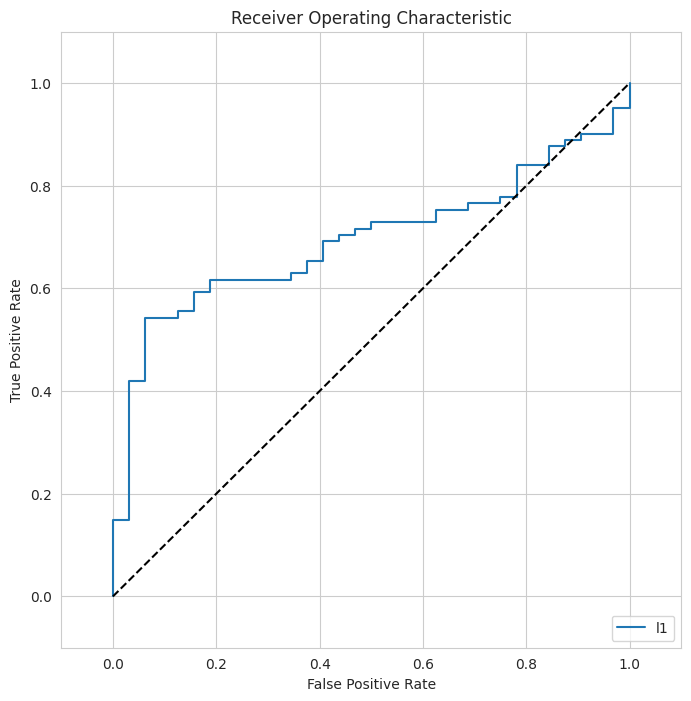

In [630]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [631]:
# Calculate AUC for Train set
print(roc_auc_score(y_train, y_train_pred))

0.5380781212556913


In [632]:
# Calculate AUC for Test set
print(auc(fpr, tpr))

0.6940586419753086


In [633]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.7758
Test  ROC-AUC: 0.6941
Test  PR-AUC : 0.8778


#### Feature Importance

In [634]:
## Building the model again with the best hyperparameters
model = LogisticRegression(C=1, penalty = 'l2')
model.fit(X_train, y_train)

LogisticRegression(C=1)

In [635]:
indices = np.argsort(-abs(model.coef_[0,:]))
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Alamine_Aminotransferase
Direct_Bilirubin
Aspartate_Aminotransferase
Albumin
Total_Bilirubin
Total_Protiens
Alkaline_Phosphotase
Age
Gender
Albumin_and_Globulin_Ratio


## Model-2 Random Forest

In [636]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomizedSearchCV(RandomForestClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='roc_auc')

In [637]:
model.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [638]:
y_train_pred = model.predict(X_train)

In [639]:
y_pred = model.predict(X_test)

In [640]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [641]:
# Display first 10 predictions
y_pred_proba[:10]

array([0.64588889, 0.63915873, 0.61619048, 0.55969643, 0.28195887,
       0.98383333, 0.50340079, 0.49206944, 0.96691667, 0.38770238])

In [642]:
confusion_matrix(y_test, y_pred).T

array([[ 5, 11],
       [27, 70]])

In [643]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

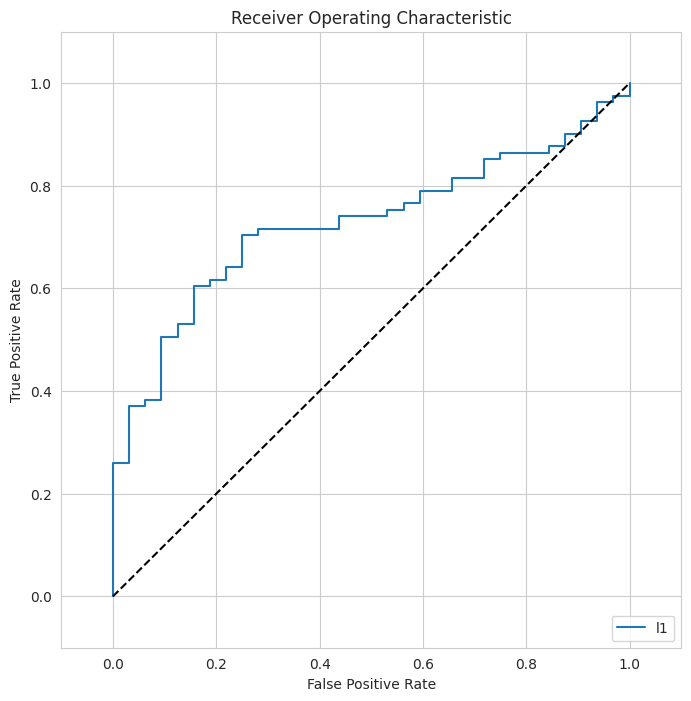

In [644]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [645]:
# Calculate AUC for Train set
roc_auc_score(y_train, y_train_pred)

np.float64(0.9615384615384616)

In [646]:
# Calculate AUC for Test set
print(auc(fpr, tpr))

0.7260802469135803


In [647]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.9995
Test  ROC-AUC: 0.7261
Test  PR-AUC : 0.8901


#### Feature Importance

In [648]:
## Building the model again with the best hyperparameters
model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=4)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=500)

In [649]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Alkaline_Phosphotase
Aspartate_Aminotransferase
Total_Bilirubin
Alamine_Aminotransferase
Age
Direct_Bilirubin
Albumin
Albumin_and_Globulin_Ratio
Total_Protiens
Gender


## Model-3 XGBoost

In [650]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=No...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_lambda': [0.001, 0.1, 1.0, 10.0,
                                                       100.0]},
                   scoring='roc_auc')

In [651]:
model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [652]:
y_train_pred = model.predict(X_train)

In [653]:
y_pred = model.predict(X_test)

In [654]:
# Get just the prediction for the positive class (1)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [655]:
# Display first 10 predictions
y_pred_proba[:10]

array([0.72681534, 0.5366961 , 0.5507277 , 0.56749946, 0.32101858,
       0.94821244, 0.48863715, 0.5758587 , 0.9375292 , 0.47174716],
      dtype=float32)

In [656]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.8301
Test  ROC-AUC: 0.6970
Test  PR-AUC : 0.8623


**Note:** Just as above we can use these probabilities to get model interpretation

In [657]:
confusion_matrix(y_test, y_pred).T

array([[ 7, 14],
       [25, 67]])

In [658]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

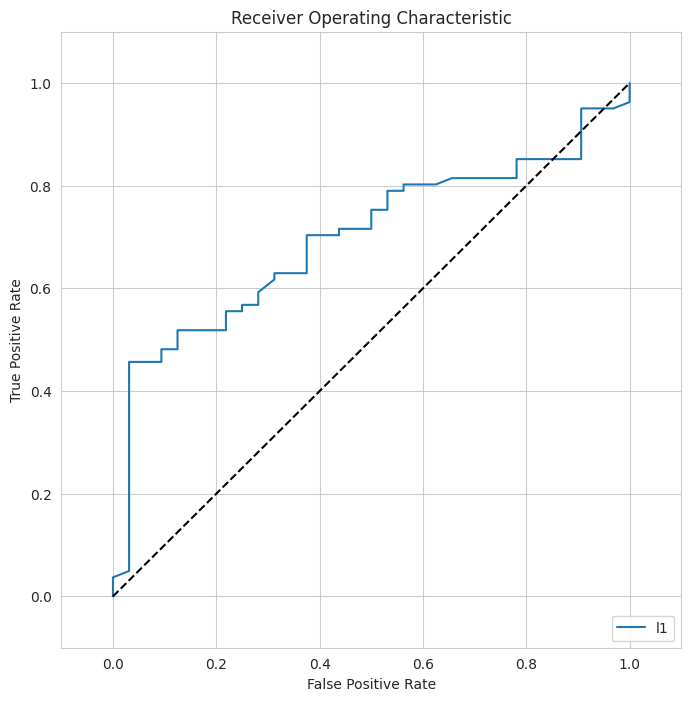

In [659]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [660]:
# Calculate AUC for Train
roc_auc_score(y_train, y_train_pred)

np.float64(0.678732326863168)

In [661]:
# Calculate AUC for Test
print(auc(fpr, tpr))

0.6969521604938272


#### Feature Importance

In [662]:
model = XGBClassifier(max_depth=1,learning_rate=0.05,n_estimators=500, reg_lambda=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [663]:
def my_plot_importance(booster, figsize, **kwargs):
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

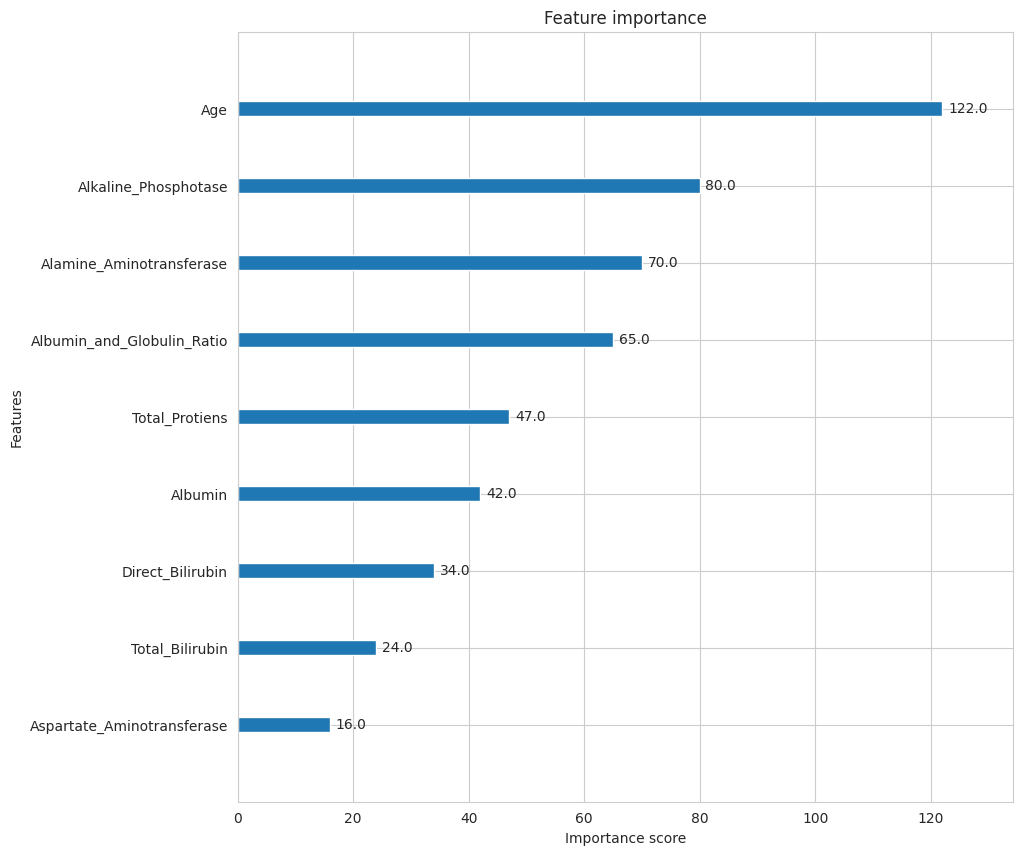

In [664]:

my_plot_importance(model, (10,10))

## Model-4 KNN

In [665]:
# creating odd list of K for KNN
neighbors = list(range(1,20,2))
# empty list that will hold cv scores
cv_scores = []

#  10-fold cross validation , 9 datapoints will be considered for training and 1 for cross validation (turn by turn) to determine value of k
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


In [666]:
MSE.index(min(MSE))

8

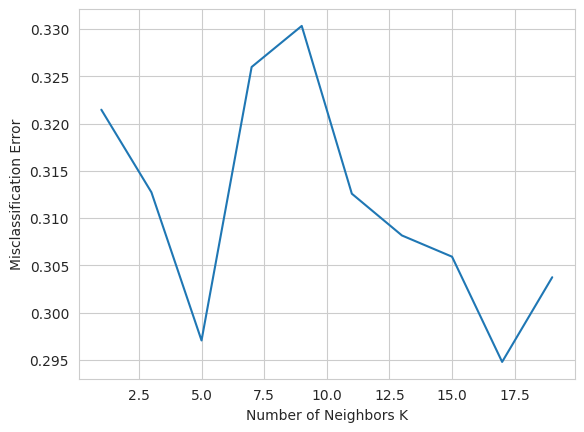

In [667]:
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [668]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [669]:
y_pred = classifier.predict(X_test)


In [670]:
y_train_pred = classifier.predict(X_train)

In [671]:
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)  ## get the accuracy on testing data
acc

69.91150442477876

In [672]:
cnf=confusion_matrix(y_test,y_pred).T
cnf

array([[ 4,  6],
       [28, 75]])

In [673]:
# Get just the prediction for the positive class (1)
y_pred_proba = classifier.predict_proba(X_test)[:,1]

In [674]:
# Display first 10 predictions
y_pred_proba[:10]

array([0.76470588, 0.64705882, 0.94117647, 0.64705882, 0.41176471,
       1.        , 0.41176471, 0.52941176, 0.64705882, 0.52941176])

In [675]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

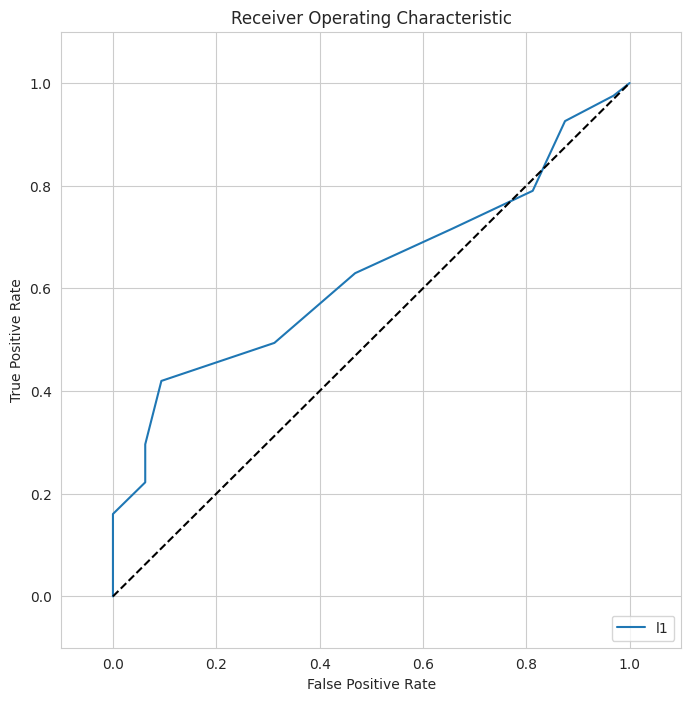

In [676]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [677]:
# Calculate AUC for Train
roc_auc_score(y_train, y_train_pred)

np.float64(0.6376947040498442)

In [678]:
# Calculate AUC for Test
print(auc(fpr, tpr))

0.6282793209876544


In [679]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.8511
Test  ROC-AUC: 0.6283
Test  PR-AUC : 0.8302


## Model-5 Descision Trees

In [680]:
tuned_params = {'min_samples_split': [2, 3, 4, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 6], 'max_depth': [2, 3, 4, 5, 6, 7]}
model = RandomizedSearchCV(DecisionTreeClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 7]},
                   scoring='roc_auc')

In [681]:
model.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [682]:
y_train_pred = model.predict(X_train)

In [683]:
y_pred = model.predict(X_test)

In [684]:
y_pred_proba = model.predict_proba(X_test)[:,1]

In [685]:
y_pred_proba[:10]

array([0.74698795, 0.54193548, 0.54193548, 0.54193548, 0.        ,
       0.976     , 0.74698795, 0.54193548, 0.976     , 0.        ])

In [686]:
confusion_matrix(y_test, y_pred).T

array([[ 1,  3],
       [31, 78]])

In [687]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

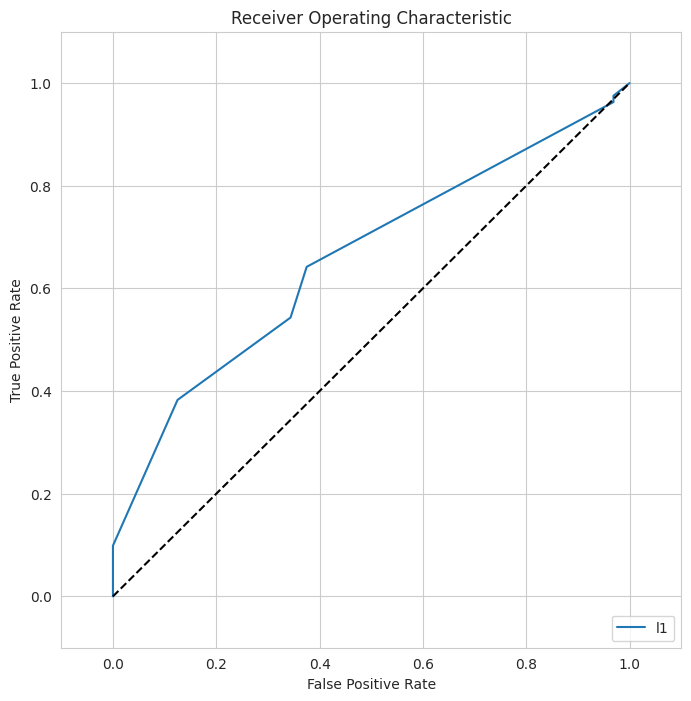

In [688]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [689]:
# Calculate AUC for Train
roc_auc_score(y_train, y_train_pred)

np.float64(0.5960579918523844)

In [690]:
print(auc(fpr, tpr))

0.6572145061728395


In [691]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.8137
Test  ROC-AUC: 0.6572
Test  PR-AUC : 0.8152


#### Feature Importance

In [692]:
## Building the model again with the best hyperparameters
model = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=6, max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6)

In [693]:
indices = np.argsort(-model.feature_importances_)
print("The features in order of importance are:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

The features in order of importance are:
--------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Age
Albumin_and_Globulin_Ratio
Aspartate_Aminotransferase
Alamine_Aminotransferase
Direct_Bilirubin
Gender
Total_Protiens
Albumin


## Model-6 SVC

In [694]:
from sklearn import svm
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

In [695]:
svClassifier=SVC(kernel='rbf',probability=True)
svClassifier.fit(X_train,y_train)

SVC(probability=True)

In [696]:
svc_param_selection(X_train,y_train,5)

{'C': 1, 'gamma': 1}

In [697]:
###### Building the model again with the best hyperparameters
model = SVC(C=1, gamma=1, probability=True)
model.fit(X_train, y_train)

SVC(C=1, gamma=1, probability=True)

In [698]:
## Predict Train results
y_train_pred = model.predict(X_train)

In [699]:
## Predict Test results
y_pred = model.predict(X_test)

In [700]:
confusion_matrix(y_test, y_pred).T

array([[ 3,  4],
       [29, 77]])

In [701]:
y_pred_proba = model.predict_proba(X_test)[:,1]

In [702]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

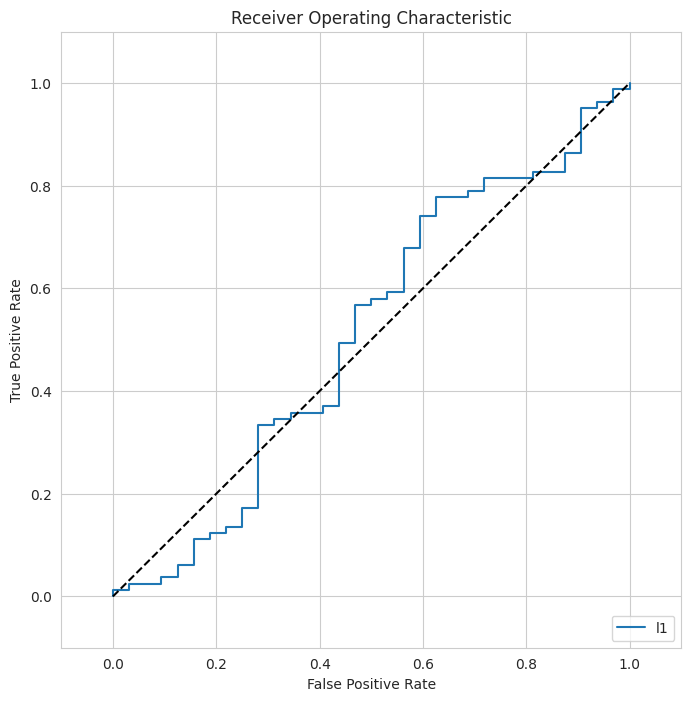

In [703]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [704]:
# Calculate AUC for Train
roc_auc_score(y_train, y_train_pred)

np.float64(0.7782890007189072)

In [705]:
print(auc(fpr, tpr))

0.5104166666666666


In [706]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.9402
Test  ROC-AUC: 0.5104
Test  PR-AUC : 0.7064


## Model-7 Gradient Boosting

In [707]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

In [708]:
#Import Library
from sklearn.ensemble import GradientBoostingClassifier
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create Gradient Boosting Classifier object
gbclass = GradientBoostingClassifier(
    random_state=1000,
    verbose=0,
    n_estimators=10,
    learning_rate=0.9,
    loss='log_loss',        # <--- replaced
    max_depth=3
)
#gbclass = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# Train the model using the training sets and check score
gbclass.fit(X_train, y_train)
#Predict Output
predicted= gbclass.predict(X_test)

gbclass_score = round(gbclass.score(X_train, y_train) * 100, 2)
gbclass_score_test = round(gbclass.score(X_test, y_test) * 100, 2)
print('Score: \n', gbclass_score)
print('Test Score: \n', gbclass_score_test)
print('Accuracy: \n', accuracy_score(y_test,predicted))
print(confusion_matrix(predicted,y_test))
print(classification_report(y_test,predicted))

Score: 
 90.02
Test Score: 
 69.03
Accuracy: 
 0.6902654867256637
[[13 16]
 [19 65]]
              precision    recall  f1-score   support

           0       0.45      0.41      0.43        32
           1       0.77      0.80      0.79        81

    accuracy                           0.69       113
   macro avg       0.61      0.60      0.61       113
weighted avg       0.68      0.69      0.69       113



In [709]:
## Predict Train results
y_train_pred = gbclass.predict(X_train)

In [710]:
## Predict Test results
y_pred = gbclass.predict(X_test)

In [711]:
y_pred_proba = gbclass.predict_proba(X_test)[:,1]

In [712]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

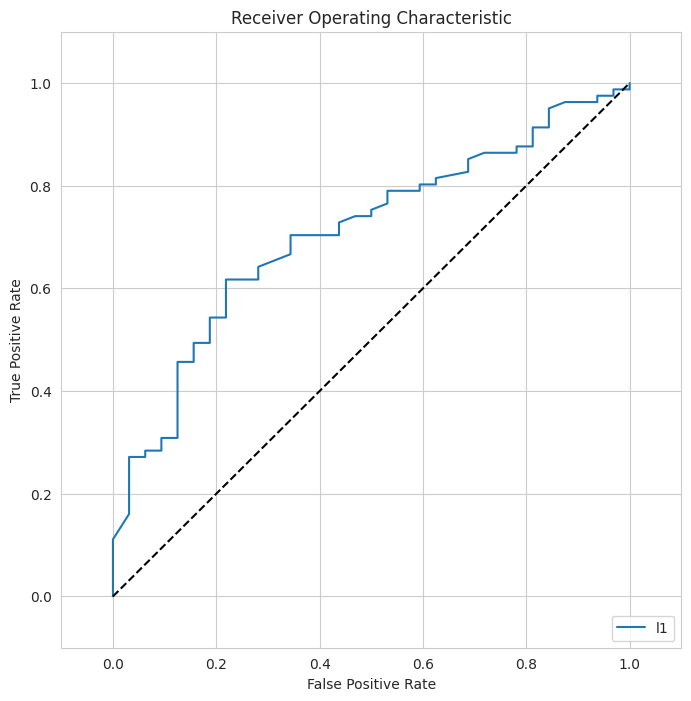

In [713]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [714]:
roc_auc_score(y_train,y_train_pred )

np.float64(0.861250898634076)

In [715]:
# Calculate AUC for Test
print(auc(fpr, tpr))

0.707175925925926


In [716]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.9402
Test  ROC-AUC: 0.7072
Test  PR-AUC : 0.8647


# Neural Networks

In [717]:
# Neural Networks# Neural
neural = MLPClassifier(hidden_layer_sizes=40,
                     activation='relu',
                     solver='adam',
                     alpha=0.001,
                     batch_size='auto',
                     max_iter=200,
                     random_state=137,
                     tol=0.0001,
                     early_stopping=False,
                     validation_fraction=0.1,
                     beta_1=0.9,
                     beta_2=0.999,
                     epsilon=1e-08,
                     learning_rate='constant',
                     power_t=0.5,
                     momentum=0.8,
                     nesterovs_momentum=True,
                     shuffle=True,
                     learning_rate_init=0.001)
neural.fit(X_train, y_train)
#Predict Output
predicted = neural.predict(X_test)

neural_score = round(neural.score(X_train, y_train) * 100, 2)
neural_score_test = round(neural.score(X_test, y_test) * 100, 2)
print('Neural Score: \n', neural_score)
print('Neural Test Score: \n', neural_score_test)
print('Accuracy: \n', accuracy_score(y_test, predicted))
print(confusion_matrix(predicted,y_test))
print(classification_report(y_test,predicted))

Neural Score: 
 77.83
Neural Test Score: 
 69.91
Accuracy: 
 0.6991150442477876
[[ 5  7]
 [27 74]]
              precision    recall  f1-score   support

           0       0.42      0.16      0.23        32
           1       0.73      0.91      0.81        81

    accuracy                           0.70       113
   macro avg       0.57      0.53      0.52       113
weighted avg       0.64      0.70      0.65       113



In [718]:
## Predict Train results
y_train_pred = neural.predict(X_train)

In [719]:
## Predict Test results
y_pred = neural.predict(X_test)

In [720]:
y_pred_proba = neural.predict_proba(X_test)[:,1]

In [721]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

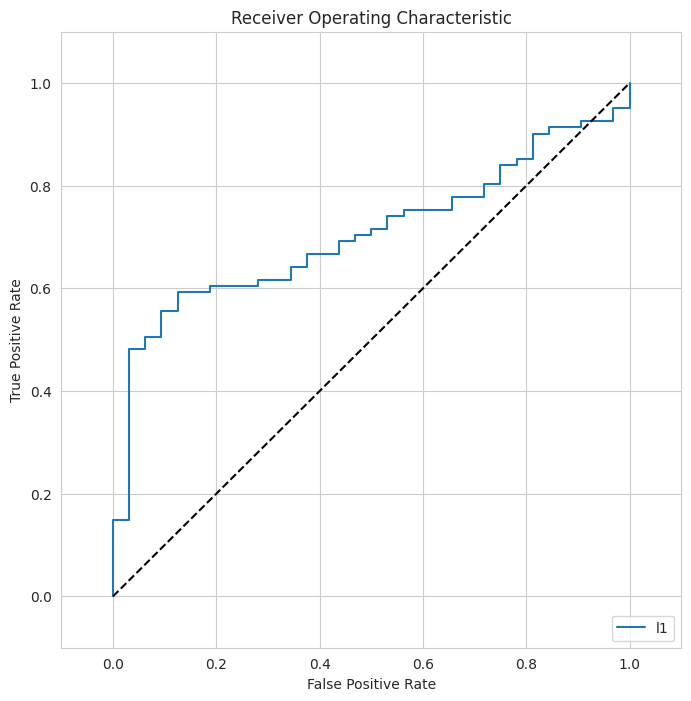

In [722]:
# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [723]:
roc_auc_score(y_train,y_train_pred )

np.float64(0.6703091301222142)

In [724]:
# Calculate AUC for Test
print(auc(fpr, tpr))

0.7060185185185185


In [725]:
# Compute ROC-AUC scores
y_train_proba = model.predict_proba(X_train)[:, 1]
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_pred_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_pred_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

=== Model Evaluation Results ===
Train ROC-AUC: 0.9402
Test  ROC-AUC: 0.7060
Test  PR-AUC : 0.8816


##  Save the winning model to disk

In [726]:
win_model = XGBClassifier(max_depth=1,learning_rate=0.05,n_estimators=500, reg_lambda=1)
win_model.fit(X_train, y_train)
with open('LiverDisease.pkl', 'wb') as pickle_file:
      joblib.dump(win_model, 'LiverDisease.pkl')

# Evaluation Cells: ROC-AUC and PR-AUC (Train & Test)


=== Model Evaluation Results ===
Train ROC-AUC: 0.8511
Test  ROC-AUC: 0.7216
Test  PR-AUC : 0.8734


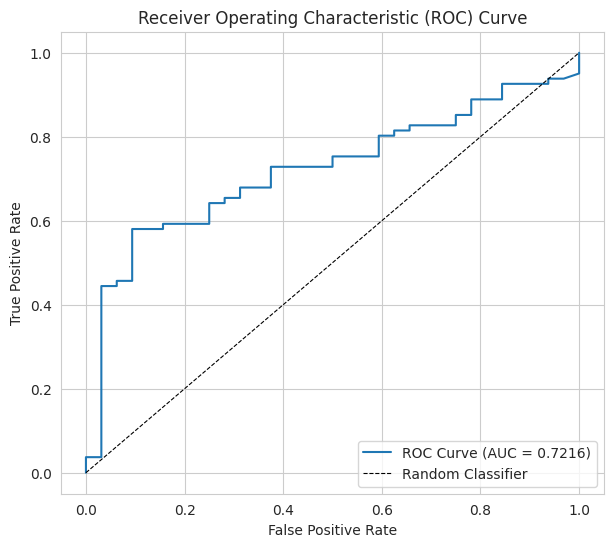

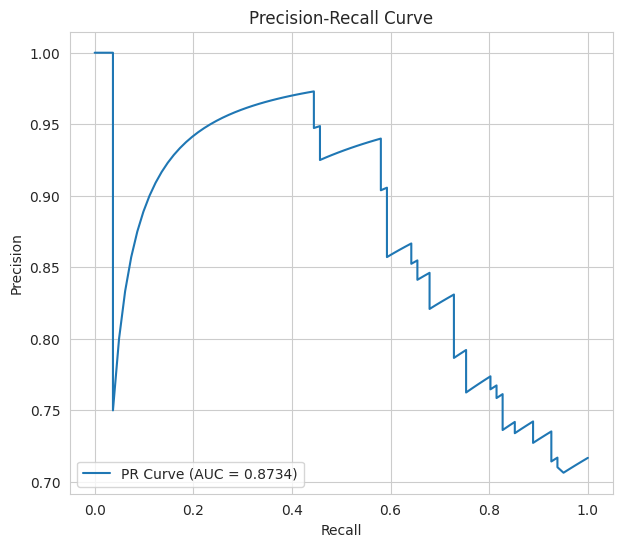

In [727]:


# Use the winning model trained previously (XGBClassifier)
model_to_evaluate = win_model # Assuming 'win_model' is available in the global scope

# Function to get prediction probabilities
def get_probabilities(model, data):
    # XGBClassifier has predict_proba, so we can directly use it
    return model.predict_proba(data)[:, 1]

# Compute probabilities
y_train_proba = get_probabilities(model_to_evaluate, X_train)
y_test_proba = get_probabilities(model_to_evaluate, X_test)

# Compute ROC-AUC scores
roc_train_auc = roc_auc_score(y_train, y_train_proba)
roc_test_auc = roc_auc_score(y_test, y_test_proba)

# Compute PR-AUC (Average Precision) for test set
pr_test_auc = average_precision_score(y_test, y_test_proba)

print("=== Model Evaluation Results ===")
print(f"Train ROC-AUC: {roc_train_auc:.4f}")
print(f"Test  ROC-AUC: {roc_test_auc:.4f}")
print(f"Test  PR-AUC : {pr_test_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_test_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()